In [20]:

from dask.distributed import Client
import matplotlib.pyplot as plt 
import numpy as np   
from matplotlib.colors import LogNorm
import lsdb
from catalog_filtering import bandFilterLenient

In [47]:

bandList = ['G','R','I','Z','Y']
crucialCols = [f'CLASS_STAR_{band}' for band in bandList] + [f'FLAGS_{band}' for band in bandList] + ['RA','DEC','HPIX_1024','HPIX_4096'] + [f'SPREAD_MODEL_{band}' for band in bandList] + [f'WAVG_MAG_PSF_{band}' for band in bandList] + [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
catalog = lsdb.read_hipscat('hipscat/des_one_deg/', columns=crucialCols)

qs = bandFilterLenient(bandList,classStar=0.95,spreadModel=0.05,magError=0.05,flag=True,invalidMags=True)
print(qs)
filtered_catalog = catalog.query(qs)

xmatch = filtered_catalog.crossmatch(filtered_catalog, n_neighbors=100, radius_arcsec=18, suffixes=['_1', '_2'])

with Client():  
    df = xmatch.compute()

df

(CLASS_STAR_G > 0.95 and SPREAD_MODEL_G < 0.05 and FLAGS_G < 4 and WAVG_MAGERR_PSF_G < 0.05 and WAVG_MAG_PSF_G > 0 and WAVG_MAG_PSF_G < 90) or (CLASS_STAR_R > 0.95 and SPREAD_MODEL_R < 0.05 and FLAGS_R < 4 and WAVG_MAGERR_PSF_R < 0.05 and WAVG_MAG_PSF_R > 0 and WAVG_MAG_PSF_R < 90) or (CLASS_STAR_I > 0.95 and SPREAD_MODEL_I < 0.05 and FLAGS_I < 4 and WAVG_MAGERR_PSF_I < 0.05 and WAVG_MAG_PSF_I > 0 and WAVG_MAG_PSF_I < 90) or (CLASS_STAR_Z > 0.95 and SPREAD_MODEL_Z < 0.05 and FLAGS_Z < 4 and WAVG_MAGERR_PSF_Z < 0.05 and WAVG_MAG_PSF_Z > 0 and WAVG_MAG_PSF_Z < 90) or (CLASS_STAR_Y > 0.95 and SPREAD_MODEL_Y < 0.05 and FLAGS_Y < 4 and WAVG_MAGERR_PSF_Y < 0.05 and WAVG_MAG_PSF_Y > 0 and WAVG_MAG_PSF_Y < 90)


/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,CLASS_STAR_G_1,CLASS_STAR_R_1,CLASS_STAR_I_1,CLASS_STAR_Z_1,CLASS_STAR_Y_1,FLAGS_G_1,FLAGS_R_1,FLAGS_I_1,FLAGS_Z_1,FLAGS_Y_1,...,WAVG_MAG_PSF_R_2,WAVG_MAG_PSF_I_2,WAVG_MAG_PSF_Z_2,WAVG_MAG_PSF_Y_2,WAVG_MAGERR_PSF_G_2,WAVG_MAGERR_PSF_R_2,WAVG_MAGERR_PSF_I_2,WAVG_MAGERR_PSF_Z_2,WAVG_MAGERR_PSF_Y_2,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10369036480038305792,0.652741,0.212499,0.967461,0.278183,0.194381,0,0,0,0,0,...,23.5951,22.538921,21.984833,-99.0,-99.0,0.065632,0.039918,0.038185,-99.0,0.0
10369036678043009024,0.968063,0.979521,0.983165,0.981892,0.980741,3,3,3,3,3,...,-99.0,20.495581,19.898781,19.713318,-99.0,-99.0,0.008536,0.006411,0.033931,0.0
10369036678043009024,0.968063,0.979521,0.983165,0.981892,0.980741,3,3,3,3,3,...,18.644403,17.988743,17.675734,17.59296,0.002933,0.001319,0.001088,0.001137,0.00384,2.361605
10369036678261112832,0.982102,0.983182,0.984217,0.985534,0.962354,3,3,3,3,3,...,18.644403,17.988743,17.675734,17.59296,0.002933,0.001319,0.001088,0.001137,0.00384,0.0
10369036678261112832,0.982102,0.983182,0.984217,0.985534,0.962354,3,3,3,3,3,...,-99.0,20.495581,19.898781,19.713318,-99.0,-99.0,0.008536,0.006411,0.033931,2.361605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10374613634851536896,0.982251,0.984246,0.98358,0.983546,0.930587,0,0,0,0,0,...,20.181368,18.991371,18.480366,18.361776,0.01016,0.003785,0.002197,0.002048,0.007218,0.0
10374613652320813056,0.567486,0.423528,0.963686,0.42057,0.271158,0,0,0,0,0,...,23.206591,22.758615,22.452892,-99.0,0.062541,0.069027,0.047158,0.083787,-99.0,0.0
10374613652320813056,0.567486,0.423528,0.963686,0.42057,0.271158,0,0,0,0,0,...,20.299086,19.67638,19.367739,19.285269,0.010185,0.004546,0.003375,0.004407,0.015827,5.93719


Text(0.5, 1.0, 'Distance between Stars in Arcseconds')

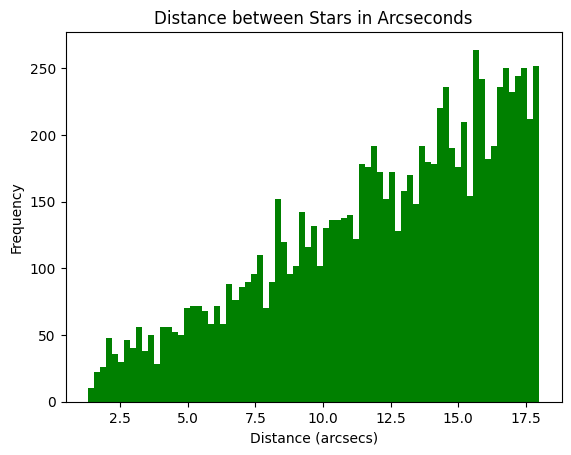

In [22]:
mask = df['_dist_arcsec'] > 0
no_doubles_dist = df['_dist_arcsec'][mask]


plt.hist(no_doubles_dist, bins = 75, color = 'green')
plt.xlabel('Distance (arcsecs)')
plt.ylabel('Frequency')
plt.title('Distance between Stars in Arcseconds')

_hipscat_index
10369036480038305792    0
10369036678043009024    1
10369036678261112832    1
10369036749258096640    1
10369036758653337600    1
                       ..
10374608150782279680    0
10374613603239067648    0
10374613634851536896    0
10374613652320813056    1
10374613652723466240    1
Name: _dist_arcsec, Length: 19550, dtype: int64[pyarrow]


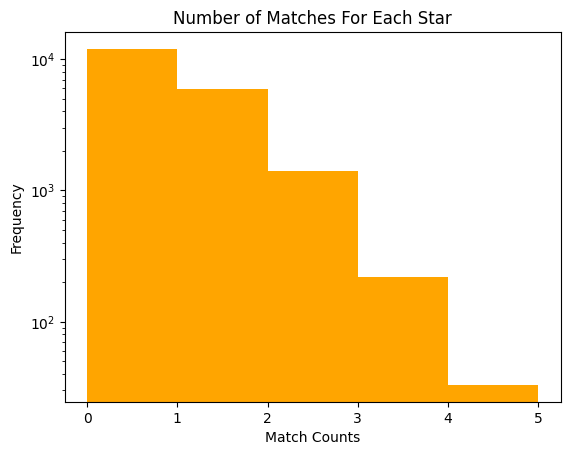

In [32]:
counts = df.groupby('_hipscat_index')['_dist_arcsec'].count()
counts -= 1 #Double counting adjustment
plt.hist(counts, color = 'orange', bins= [i for i in range(0,6)])
plt.xlabel('Match Counts')
plt.ylabel('Frequency')
plt.title('Number of Matches For Each Star')
plt.yscale('log')



Text(0.5, 1.0, 'Matched Stars Graphed by Displacement from Eachother')

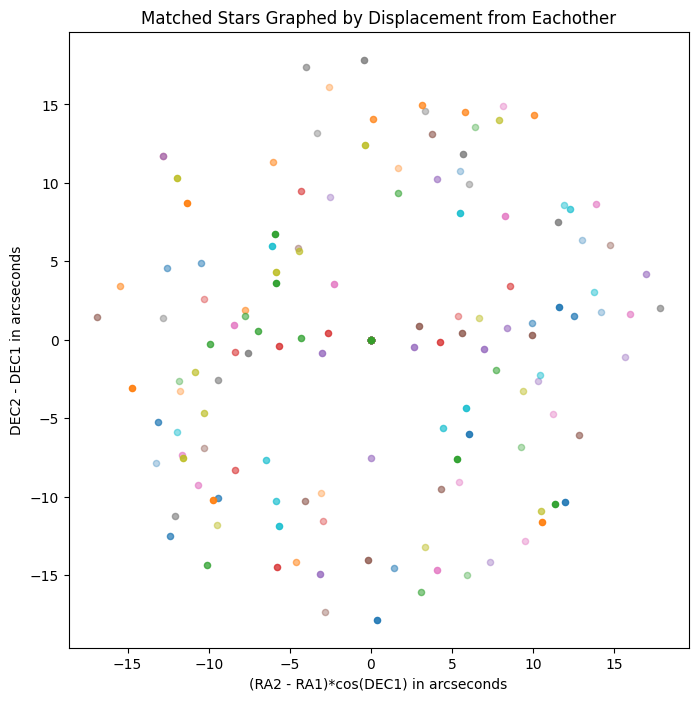

In [118]:
df['counts'] = counts
four_or_more_matches = df.query('counts >= 4')


plt.figure(figsize=(8, 8))
alpha = .3
#Loop through groups of matched stars
for _hipscat_index, group in four_or_more_matches.groupby('_hipscat_index'):
    #origin point
    ra1, dec1 = group.iloc[0][["RA_1", "DEC_1"]]
    
    #array of matched points
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T

    #perform delta RA, DEC calculations
    x = (ra2 - ra1) * np.cos(np.radians(dec1)) * 3600
    y = (dec2 - dec1) * 3600
        
    plt.scatter(x, y, s=20, alpha=alpha)
    alpha += 0.02

plt.xlabel('(RA2 - RA1)*cos(DEC1) in arcseconds')
plt.ylabel('DEC2 - DEC1 in arcseconds')
plt.title('Matched Stars Graphed by Displacement from Eachother')


#color map for different system 
#check if id1 is the same as the min of id2, then graph


In [119]:
#2 millescond distance from the line 
#put geometry in notebook
def closeToProjection(slope, x, y, error):
    distance = abs(-slope * x + y)/(slope**2 + 1)**0.5
    return distance < (error)


plt.figure(figsize=(8, 8))
for _hipscat_index, group in four_or_more_matches.groupby('_hipscat_index'):
    #origin point
    ra1, dec1 = group.iloc[0][["RA_1", "DEC_1"]]
    
    #array of matched points
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T

    #perform delta RA, DEC calculations
    x_vals = (ra2 - ra1) * np.cos(np.radians(dec1)) * 3600
    y_vals = (dec2 - dec1) * 3600
    coords = zip(x_vals, y_vals)
    coords = list(coords)


    for i in range(len(coords)):
        found = 0
        x,y = coords[i]
        if y == 0: continue
        slope = (x/y)

        for j in range(len(coords)):
            if j == i: continue
            test_x, test_y = coords[j]
            if closeToProjection(slope, test_x, test_y, 0.2):
                found += 1
        if found >= 3:
            plt.scatter(x_vals, y_vals, s=20, alpha=alpha)
            print(ra1, dec1)




    


<Figure size 800x800 with 0 Axes>